In [1]:
import json
import os

In [3]:
kaggle_credentials = json.load(open("kaggle.json"))

In [4]:
#setup Kaggle API key as enviroment variables
os.environ['KAGGLE_USERNAME'] = kaggle_credentials['username']
os.environ['KAGGLE_KEY'] = kaggle_credentials['key']

In [5]:
!kaggle datasets download -d omkargurav/face-mask-dataset

 98% 160M/163M [00:08<00:00, 22.9MB/s]
100% 163M/163M [00:08<00:00, 20.0MB/s]


In [6]:
from zipfile import ZipFile
dataset = '/content/face-mask-dataset.zip'

with ZipFile(dataset, 'r') as zip:
  zip.extractall()
  print("the dataset is extracted")

the dataset is extracted


In [7]:
!ls

data  face-mask-dataset.zip  kaggle.json  sample_data


## Importing dependencies

In [8]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cv2
from google.colab.patches import cv2_imshow
from PIL import Image

from sklearn.model_selection import train_test_split

In [9]:
with_mask_files = os.listdir('/content/data/with_mask')
print(with_mask_files[0:5])
print(with_mask_files[-5:])

['with_mask_1581.jpg', 'with_mask_1932.jpg', 'with_mask_1982.jpg', 'with_mask_434.jpg', 'with_mask_3656.jpg']
['with_mask_2483.jpg', 'with_mask_1887.jpg', 'with_mask_3512.jpg', 'with_mask_2361.jpg', 'with_mask_2670.jpg']


In [10]:
without_mask_files = os.listdir('/content/data/without_mask')
print(without_mask_files[0:5])
print(without_mask_files[-5:])

['without_mask_3403.jpg', 'without_mask_679.jpg', 'without_mask_2559.jpg', 'without_mask_3285.jpg', 'without_mask_1696.jpg']
['without_mask_1082.jpg', 'without_mask_1534.jpg', 'without_mask_1654.jpg', 'without_mask_2579.jpg', 'without_mask_3804.jpg']


In [11]:
print('Number of images with mask: ', len(with_mask_files))
print('Number of images without mask: ', len(without_mask_files))

Number of images with mask:  3725
Number of images without mask:  3828


## Creating labels

In [12]:
with_masks_labels = [1]*3725
without_masks_labels = [0]*3828

In [13]:
labels = with_masks_labels + without_masks_labels

print(len(labels))

7553


## Displaying images

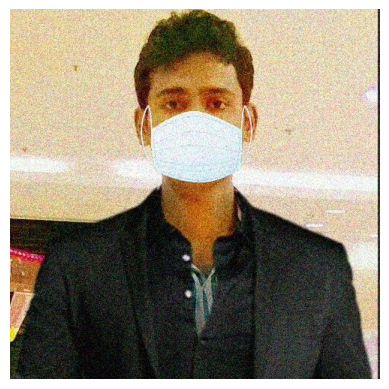

In [14]:
img_mask = mpimg.imread('/content/data/with_mask/with_mask_1932.jpg')
plt.axis('off')
plt.imshow(img_mask);

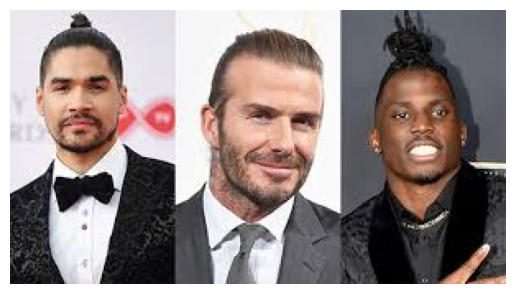

In [15]:
img_without_mask = mpimg.imread('/content/data/without_mask/without_mask_2579.jpg')
plt.axis('off')
plt.imshow(img_without_mask);

## Image processing

In [16]:
with_mask_path = '/content/data/with_mask/'
data =[]

for img_file in with_mask_files:
  image = Image.open(with_mask_path + img_file)
  image = image.resize((128,128))
  image = image.convert('RGB')
  image = np.array(image)
  data.append(image)

without_mask_path = '/content/data/without_mask/'

for img_file in without_mask_files:
  image = Image.open(without_mask_path + img_file)
  image = image.resize((128,128))
  image = image.convert('RGB')
  image = np.array(image)
  data.append(image)

/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


In [17]:
len(data)

7553

In [18]:
print(type(data[0]))
print(data[0].shape)

<class 'numpy.ndarray'>
(128, 128, 3)


## Train-test split

In [19]:
#converting image list and labels list to numpy array

X = np.array(data)
y = np.array(labels)

In [20]:
print(X.shape)
print(y.shape)

(7553, 128, 128, 3)
(7553,)


In [21]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2)

In [22]:
X_train_scaled = X_train/255.0
X_test_scaled = X_test/255.0

## Model Architecture

In [23]:
import tensorflow as tf
from tensorflow import keras

In [24]:
num_classes = 2
batch_size = 32

In [25]:
model = keras.Sequential()

model.add(keras.layers.Conv2D(32, kernel_size = (2,2), activation = 'relu', input_shape = (128,128,3)))
model.add(keras.layers.MaxPooling2D(pool_size = (2,2)))

model.add(keras.layers.Conv2D(64, kernel_size = (3,3), activation = 'relu'))
model.add(keras.layers.MaxPooling2D(pool_size = (2,2)))

model.add(keras.layers.Conv2D(128, kernel_size = (3,3), activation = 'relu'))
model.add(keras.layers.MaxPooling2D(pool_size = (2,2)))

model.add(keras.layers.Flatten())

model.add(keras.layers.Dense(128, activation='relu'))
model.add(keras.layers.Dropout(0.5))

model.add(keras.layers.Dense(64, activation='relu'))
model.add(keras.layers.Dropout(0.5))

model.add(keras.layers.Dense(num_classes, activation='sigmoid'))

In [26]:
Early_Stopper = tf.keras.callbacks.EarlyStopping(monitor = "loss", patience = 3, mode = "min")
Reduce_Model = tf.keras.callbacks.ReduceLROnPlateau(monitor = "accuracy", factor = 0.1, patience = 7)

In [27]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 127, 127, 32)      416       
                                                                 
 max_pooling2d (MaxPooling2  (None, 63, 63, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 61, 61, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 30, 30, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 28, 28, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 14, 14, 128)       0

In [28]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['acc'])

In [29]:
history = model.fit(X_train_scaled, y_train, validation_split=0.1, epochs=15)

Epoch 1/15
170/170 [==============================] - 11s 29ms/step - loss: 0.4158 - acc: 0.8168 - val_loss: 0.2489 - val_acc: 0.8975
Epoch 2/15
170/170 [==============================] - 3s 19ms/step - loss: 0.2751 - acc: 0.8970 - val_loss: 0.2054 - val_acc: 0.9074
Epoch 3/15
170/170 [==============================] - 3s 19ms/step - loss: 0.2218 - acc: 0.9108 - val_loss: 0.2230 - val_acc: 0.9174
Epoch 4/15
170/170 [==============================] - 4s 22ms/step - loss: 0.1895 - acc: 0.9259 - val_loss: 0.1471 - val_acc: 0.9405
Epoch 5/15
170/170 [==============================] - 3s 19ms/step - loss: 0.1682 - acc: 0.9347 - val_loss: 0.1551 - val_acc: 0.9388
Epoch 6/15
170/170 [==============================] - 3s 19ms/step - loss: 0.1569 - acc: 0.9437 - val_loss: 0.1278 - val_acc: 0.9587
Epoch 7/15
170/170 [==============================] - 3s 19ms/step - loss: 0.1204 - acc: 0.9570 - val_loss: 0.1168 - val_acc: 0.9570
Epoch 8/15
170/170 [==============================] - 4s 21ms/step -

# Model Evaluation

In [30]:
loss , accuracy = model.evaluate(X_test_scaled,y_test)
print("Test Accuracy : ",accuracy)

48/48 [==============================] - 1s 11ms/step - loss: 0.1745 - acc: 0.9629
Test Accuracy :  0.9629384279251099


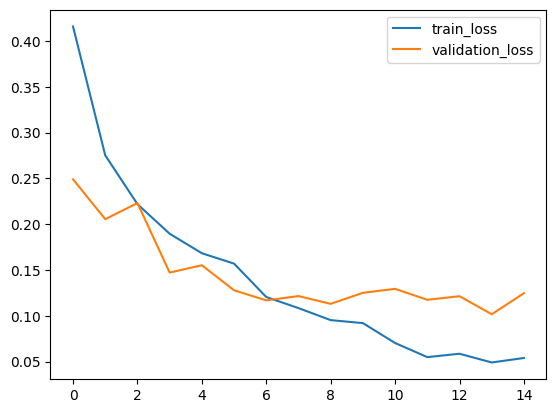

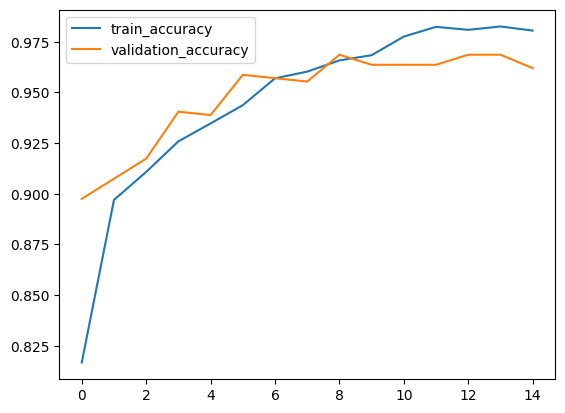

In [31]:
h = history

#plot the loss value
plt.plot(h.history['loss'],label='train_loss')
plt.plot(h.history['val_loss'],label='validation_loss')
plt.legend()
plt.show()

#plot the accuracy value
plt.plot(h.history['acc'],label='train_accuracy')
plt.plot(h.history['val_acc'],label='validation_accuracy')
plt.legend()
plt.show()

In [32]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [34]:
model.save('/content/drive/MyDrive/FACE MASK DETECTION/face_mask_detection_model.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
